# 载入&数据初步可视化

In [2]:
%matplotlib inline
import zipfile, os
import torch, torchvision
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from d2l import torch as d2l
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# 用相对路径指定zip文件
zip_path = zip_path = "/home/ly/miniconda3/envs/shiwei/data/classify-leaves.zip"
# 打开zip文件
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # 解压到当前目录
    zip_ref.extractall('/home/ly/miniconda3/envs/shiwei/data//classify-leaves')

In [4]:
labels_dataframe = pd.read_csv('/home/ly/miniconda3/envs/shiwei/data//classify-leaves/train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [5]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


In [6]:
grouped_labels = labels_dataframe.groupby('label').describe()
print(grouped_labels)

                   image                             
                   count unique              top freq
label                                                
abies_concolor       176    176   images/167.jpg    1
abies_nordmanniana    93     93  images/1284.jpg    1
acer_campestre        80     80  images/1922.jpg    1
acer_ginnala          86     86  images/1916.jpg    1
acer_griseum          64     64  images/4781.jpg    1
...                  ...    ...              ...  ...
ulmus_parvifolia      99     99  images/1152.jpg    1
ulmus_procera         58     58  images/3756.jpg    1
ulmus_pumila         189    189   images/104.jpg    1
ulmus_rubra          235    235     images/6.jpg    1
zelkova_serrata      115    115   images/365.jpg    1

[176 rows x 4 columns]


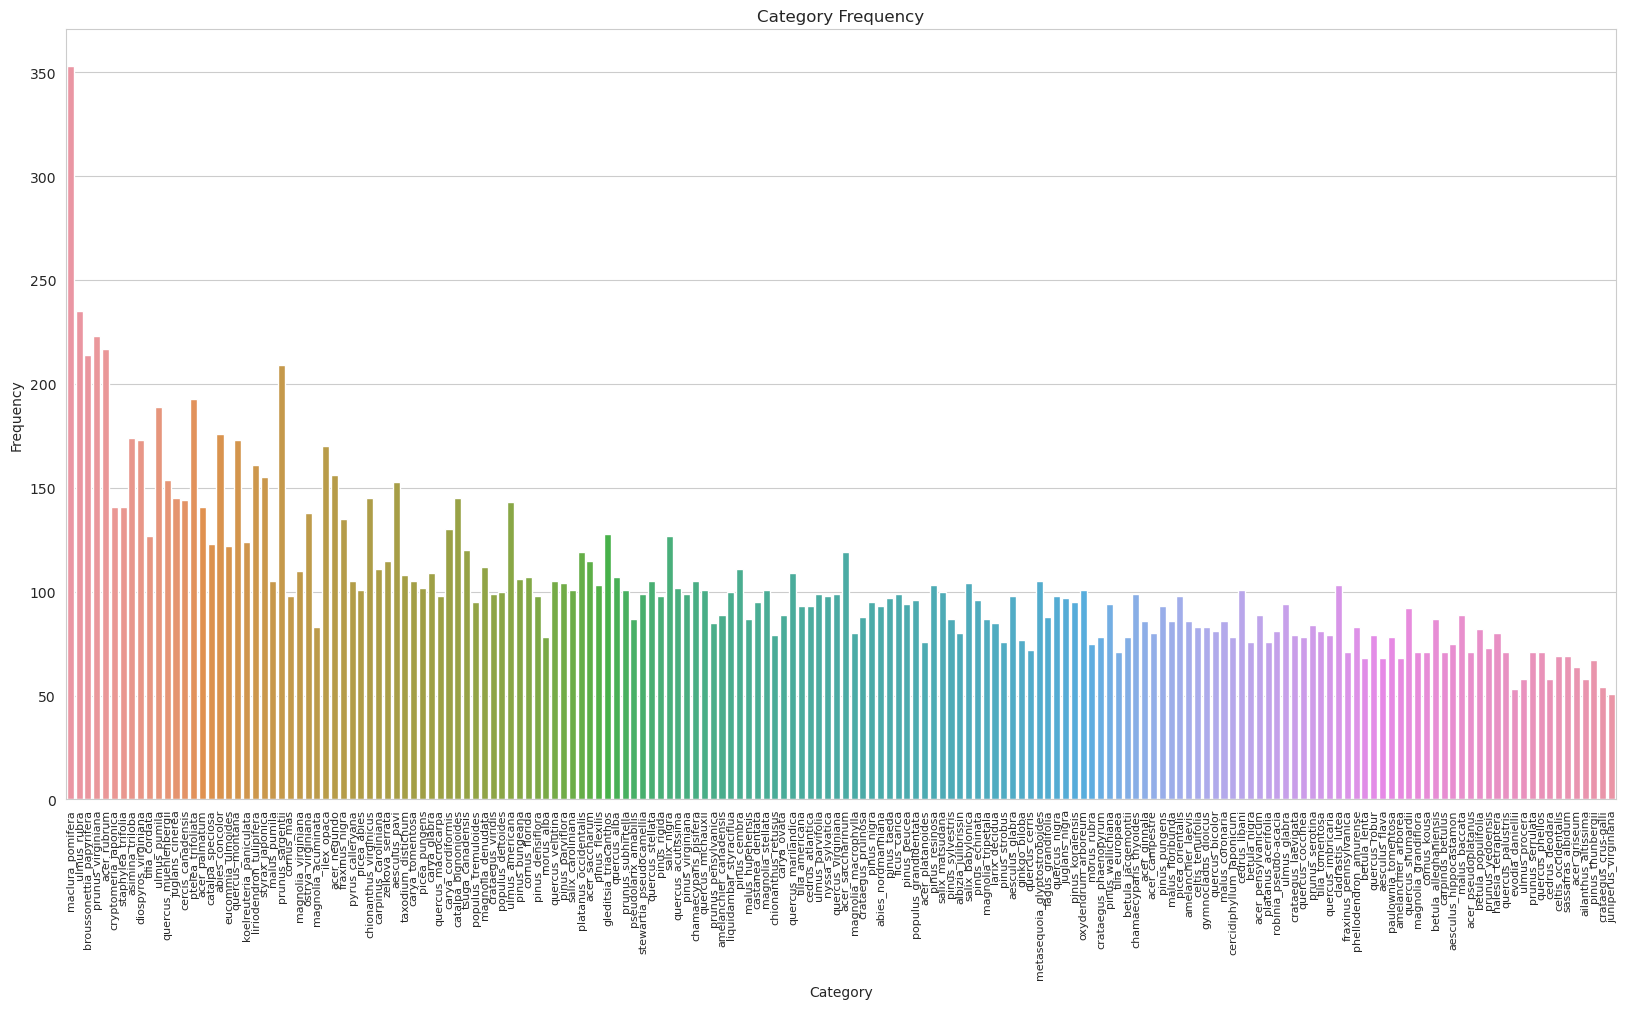

In [7]:
# 设置图形尺寸，更宽以适应所有标签
plt.figure(figsize=(20, 10))

# 绘制条形图
sns.countplot(x='label', data=labels_dataframe)
plt.title('Category Frequency')
plt.xlabel('Category')
plt.ylabel('Frequency')

# 设置x轴标签
plt.xticks(rotation=90,  # 标签旋转90度
    fontsize=8  # 减小字体大小以减少标签挤压
)
plt.show()

# 数据处理

## 类别进行顺序编码

In [8]:
labels_dataframe['label_encoded'], _ = pd.factorize(labels_dataframe['label'])
labels_dataframe

,image,label,label_encoded
0,images/0.jpg,maclura_pomifera,0
1,images/1.jpg,maclura_pomifera,0
2,images/2.jpg,maclura_pomifera,0
3,images/3.jpg,maclura_pomifera,0
4,images/4.jpg,maclura_pomifera,0
...,...,...,...
18348,images/18348.jpg,aesculus_glabra,107
18349,images/18349.jpg,liquidambar_styraciflua,75
18350,images/18350.jpg,cedrus_libani,133
18351,images/18351.jpg,prunus_pensylvanica,73


## 定义函数使得csv与图像对应起来

In [24]:
# 定义自定义数据集
class CustomDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None, test=False):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = Image.open(img_name).convert('RGB')

        if not self.test:
            label = self.img_labels.iloc[index, 2]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label)
        else:
            if self.transform:
                image = self.transform(image)
            return image


## 计算image数据的RGD通道的均值和标准差

In [10]:
images_folder = '/home/ly/miniconda3/envs/shiwei/data/classify-leaves'
# 此处注意是识别image文件夹上的那个文件，不要写成image文件

dataset = CustomDataset(labels_dataframe, images_folder, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))
loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=2)

In [11]:
def compute_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        data = data.view(data.size(0), data.size(1), -1)
        # Update total sum and squared sum
        channels_sum += torch.mean(data, dim=[0, 2])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = compute_mean_std(loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.7579, 0.7781, 0.7591])
Std: tensor([0.2479, 0.2348, 0.2630])


## 数据增广

In [12]:
# 定义预处理操作
train_trans = transforms.Compose([transforms.Resize((224, 224)), 
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.7579, 0.7781, 0.7591], [0.2479, 0.2348, 0.2630])])
valid_trans = transforms.Compose([transforms.Resize((224, 224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.7579, 0.7781, 0.7591], [0.2479, 0.2348, 0.2630])])

In [13]:
train_data, valid_data = train_test_split(labels_dataframe, test_size=0.2, random_state=42)

In [14]:
# 创建数据集和数据加载器
train_dataset = CustomDataset(train_data, images_folder, transform=train_trans)
valid_dataset = CustomDataset(valid_data, images_folder, transform=valid_trans)

train_iter = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
valid_iter = DataLoader(valid_dataset, batch_size=256, shuffle=None, num_workers=2)

In [15]:
for i, (X, y) in enumerate(train_iter):
    print(X)
    print(y)
    break

tensor([[[[ 0.9766,  0.9766,  0.9766,  ...,  0.9766,  0.9766,  0.9766],
          [ 0.9766,  0.9766,  0.9766,  ...,  0.9766,  0.9766,  0.9766],
          [ 0.9766,  0.9766,  0.9766,  ...,  0.9766,  0.9766,  0.9766],
          ...,
          [ 0.0591, -0.0516, -0.0833,  ...,  0.9766,  0.9766,  0.9766],
          [-0.0516, -0.0358, -0.2889,  ...,  0.9766,  0.9766,  0.9766],
          [-0.1466, -0.0516, -0.2257,  ...,  0.9766,  0.9766,  0.9766]],

         [[ 0.9451,  0.9451,  0.9451,  ...,  0.9451,  0.9451,  0.9451],
          [ 0.9451,  0.9451,  0.9451,  ...,  0.9451,  0.9451,  0.9451],
          [ 0.9451,  0.9451,  0.9451,  ...,  0.9451,  0.9451,  0.9451],
          ...,
          [ 0.2269,  0.1100,  0.1100,  ...,  0.9451,  0.9451,  0.9451],
          [ 0.1100,  0.1267, -0.1239,  ...,  0.9451,  0.9451,  0.9451],
          [ 0.0098,  0.1100, -0.0403,  ...,  0.9451,  0.9451,  0.9451]],

         [[ 0.9160,  0.9160,  0.9160,  ...,  0.9160,  0.9160,  0.9160],
          [ 0.9160,  0.9160,  

# 开始训练（使用预训练模型）

In [16]:
finetune_net = torchvision.models.resnet34(pretrained=True).cuda()
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 176).cuda()
nn.init.xavier_uniform_(finetune_net.fc.weight)

/home/ly/miniconda3/envs/shiwei/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ly/miniconda3/envs/shiwei/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.0202, -0.0417,  0.0247,  ..., -0.0494,  0.0236, -0.0422],
        [-0.0867,  0.0697, -0.0099,  ..., -0.0287,  0.0841,  0.0045],
        [-0.0096, -0.0490,  0.0696,  ...,  0.0775,  0.0783,  0.0391],
        ...,
        [-0.0807,  0.0284, -0.0136,  ...,  0.0656,  0.0715,  0.0367],
        [-0.0748,  0.0906, -0.0024,  ..., -0.0474, -0.0391,  0.0853],
        [ 0.0105, -0.0710, -0.0284,  ...,  0.0637, -0.0228,  0.0201]],
       device='cuda:0', requires_grad=True)

## 早停模型

In [18]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, threshold=0.95):
        """定义一个提前停止类：这个类将跟踪验证准确度，并在该损失在一定数量的epoch内没有改善时停止训练。
        patience: 在这么多epoch后停止训练，默认值为7
        min_delta: 改善的最小阈值，默认值为0
        threshold: 训练停止前，验证集准确率必须超过的阈值。默认值为0.95
        """
        self.patience = patience
        self.min_delta = min_delta
        self.threshold = threshold
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        score = val_accuracy
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f'早停计数器：{self.counter}，总计 {self.patience}')
            if self.counter >= self.patience and score >= self.threshold:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [19]:
def train_fine_tuning(net, train_iter, test_iter, learning_rate, num_epochs, param_group=True):
    """用GPU训练预训练，模型使用SGD，损失函数是交叉熵，学习率为固定学习率，采用多GPU设置模型(能用尽用)，对于fc层使用单独的学习率
    此处未进行权重初始化是因为在进入此函数封装之前，会对fc层进行单独权重初始化"""
    
    '''设置损失函数'''
    loss = nn.CrossEntropyLoss()# 如果后面是l.backward，此处什么都不写，如果后面是l.sum.backward，此处加入reduction=‘None’
    
    '''设置分类层与特征提取层不一样的学习率优化器'''
    # 如果param_group=True，输出层中的模型参数将使用十倍的学习率，其他层学习率保持低学习率
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        optimizer = torch.optim.SGD([{'params': params_1x},{'params': net.fc.parameters(),'lr': learning_rate * 10}],lr=learning_rate, weight_decay=0.001)
    else:
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,weight_decay=0.001)
   
    '''设置动图生成函数以及计数器'''
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'],ylim=[0,1])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer= d2l.Timer()
    
    '''设置多个GPU并行计算，模型的参数会在一个主GPU（这里是 devices[0]）上进行合并和更新
    每次训练迭代后，来自所有GPU的梯度会被汇总到这个主GPU上，并更新模型的参数。'''
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    '''初始化早停''' 
    early_stopping = EarlyStopping(patience=7, min_delta=0.001, threshold=0.93)
    
    '''训练过程'''
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)# 训练损失之和，训练准确率之和，样本数，预测数
        # 如果最后一个批次的大小小于其他批次，样本数量会少于预测数量。通过分别跟踪这两个数量，可以更准确地计算损失和准确率等度量指标，从而对模型的性能做出更准确的评估。
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            if isinstance(X, list):
                X = [x.to(devices[0]) for x in X]
            else:
                X = X.to(devices[0])
            y = y.to(devices[0])
            net.train()
            optimizer.zero_grad()
            y_hat= net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * y.shape[0], d2l.accuracy(y_hat, y), y.shape[0], y.numel())
                #此处X.shape[0]与y.shape[0]效果一样，均是样本数
            timer.stop()
            if (i + 1) % (len(train_iter) // 5) == 0 or i == len(train_iter) - 1:
                animator.add(epoch + (i + 1) / len(train_iter), (metric[0] / metric[2], metric[1] / metric[3], None))
                # 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
        # 更新早停的状态
        early_stopping(test_acc)
        if early_stopping.early_stop:
            print("早停触发")
            break
            
    print(f'loss {metric[0] / metric[2]:.3f}, 训练精度{metric[1] / metric[3]:.3f}, 测试精度{test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec,平均批次时间 {timer.sum() / num_epochs:.3f} sec',f'在{str(devices)}')

早停计数器：8，总计 7
早停触发
loss 0.044, 训练精度0.989, 测试精度0.931
1006.3 examples/sec,平均批次时间 14.590 sec 在[device(type='cuda', index=0), device(type='cuda', index=1)]


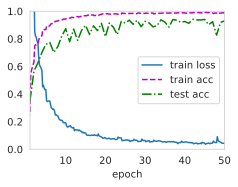

In [20]:
train_fine_tuning(finetune_net, train_iter, valid_iter, learning_rate=5e-2, num_epochs=50, param_group=True)

# 输出结果

In [30]:
test_df = pd.read_csv('/home/ly/miniconda3/envs/shiwei/data//classify-leaves/test.csv')
test_dataset = CustomDataset(test_df, images_folder, transform=valid_trans, test=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=2)

In [31]:
finetune_net.cpu()
finetune_net.eval()

predictions = []
with torch.no_grad():
    for images in test_loader:
        outputs = finetune_net(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

In [32]:
# 假设labels_df是包含所有标签和编码的DataFrame
label_decoder = {row['label_encoded']: row['label'] for index, row in labels_dataframe.iterrows()}

# 预测的编码转换回类别名
decoded_predictions = [label_decoder[label] for label in predictions]

In [35]:
# 将预测结果添加到 test.csv 并保存
test_df['label'] = decoded_predictions
test_df.to_csv('/home/ly/miniconda3/envs/shiwei/data//classify-leaves/resnet34.csv', index=False)